In [4]:
from typing import Annotated,Literal,Sequence,TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage,HumanMessage
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.pydantic_v1 import BaseModel,Field
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import START,END,StateGraph
from langgraph.prebuilt import ToolNode

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

/home/mohan/miniconda3/envs/llm_dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from langchain_groq import ChatGroq

llm = ChatGroq(temperature=0, groq_api_key= "api-key groq", model_name="gemma2-9b-it")

llm.invoke("Hello, how are you?")

AIMessage(content="As an AI, I don't have feelings, but I'm here and ready to assist you! How can I help you today?\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 15, 'total_tokens': 47, 'completion_time': 0.058181818, 'prompt_time': 0.001985817, 'queue_time': 0.236001621, 'total_time': 0.060167635}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-3d06fe3f-dba0-49b9-bdc0-97bc7d24d735-0', usage_metadata={'input_tokens': 15, 'output_tokens': 32, 'total_tokens': 47})

In [9]:
urls = [
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
]

docs = [WebBaseLoader(url).load() for url in urls]

In [13]:
docs[0][0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/',
 'title': "Prompt Engineering | Lil'Log",
 'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.',
 'language': 'en'}

In [16]:
doc_list = [item for sublist in docs for item in sublist]
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100,
    chunk_overlap=5
)


doc_split = text_splitter.split_documents(doc_list)

print(len(doc_split))

277


In [24]:
doc_split[0]

Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'title': "Prompt Engineering | Lil'Log", 'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'language': 'en'}, page_content="Prompt Engineering | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n

In [29]:
vector_store = Chroma.from_documents(
    documents=doc_split,
    embedding=embeddings,
    collection_name="rag-chrome",
)


In [62]:
retriever = vector_store.as_retriever()


retriever_tool = create_retriever_tool(
    retriever,
    "retriever_blog_posts",
    "Search and return information about Lilian Weng's blog posts on LLM agents and prompt engineering",
)

tools = [retriever_tool]

In [87]:
from langchain_core.messages import AIMessage

def AI_Assistant(state):
    print("--Calling AI Assistant--")
    message = state['messages']
    model_with_tools = llm.bind_tools(tools)
    response = model_with_tools.invoke(message)
    return {"messages": [response]}



def rewrite(state):
    print('--Calling rewriter--')
    message = state['messages']
    question = message[0].content
    msg = [
        HumanMessage(
            content=f"Rewrite the following question to be more specific and concise: {question}"
        )
    ]
    response = llm.invoke(msg)
    return {"messages": [response]}

def generate(state):
    print("--Calling generate--")
    message = state['messages']
    question = message[0].content
    last_message = message[-1]
    docs = last_message.content
    
    prompt = hub.pull('rlm/rag-prompt')
    chain = prompt | llm | StrOutputParser()
    response = chain.invoke({"context":docs,"question":question})
    AI_response = AIMessage(content=response)
    return {"messages": [AI_response]}

In [88]:
class grade(BaseModel):
    binary_score:str = Field(description="Relevance score 'yes' or 'no'")

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],add_messages]

In [89]:
def grade_document(state):
    print('--Calling grade_document--')
    llm_with_struct = llm.with_structured_output(grade)

    prompt = PromptTemplate(
        template="""
        You are a helpful assistant that can grade the relevance of a document to a question.
        Here is the question: {question}
        Here is the document: {document}
        Please grade the relevance 'yes' or 'no' of the document to the question.
        """,
        input_variables=["question","document"]
    )

    messages = state['messages']
    question = messages[0].content
    last_message = messages[-1]
    document = last_message.content
    chain = prompt | llm_with_struct
    response = chain.invoke({"question":question,"document":document})
    score = response.binary_score
    print(f"Score: {score}")
    if score == 'yes':
        return "generator"
    else:
        return "rewriter"

In [90]:
workflow = StateGraph(AgentState)
workflow.add_node("ai_assistant",AI_Assistant)
retrieve = ToolNode([retriever_tool])
workflow.add_node("retriever",retrieve)
workflow.add_node("rewriter",rewrite)
workflow.add_node("generator",generate)


workflow.add_edge(START, "ai_assistant")
workflow.add_conditional_edges(
    "ai_assistant",
    tools_condition,
    {"tools": "retriever",
     END: END})

workflow.add_conditional_edges(
    "retriever",
    grade_document,
    {
        "rewriter": "rewriter",
        "generator": "generator",
    },
)

workflow.add_edge("generator",END)
workflow.add_edge("rewriter", "retriever")


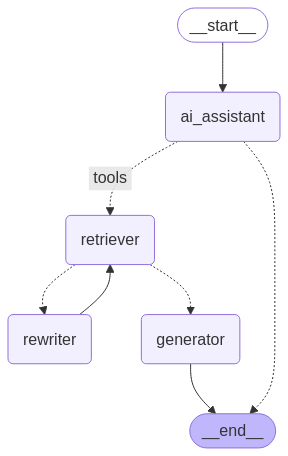

In [91]:
from IPython.display import Image

app = workflow.compile()

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)






In [94]:

response = app.invoke({"messages": ["What is current pm of india?"]})

--Calling AI Assistant--
--Calling grade_document--
Score: no
--Calling rewriter--
--Calling grade_document--
Score: yes
--Calling generate--


/home/mohan/miniconda3/envs/llm_dev/lib/python3.12/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [95]:
response['messages']

[HumanMessage(content='What is current pm of india?', additional_kwargs={}, response_metadata={}, id='576e6dcd-a89c-45eb-a0c0-90cda30467d0'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_t9hh', 'function': {'arguments': '{"query":"current pm of india"}', 'name': 'retriever_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 975, 'total_tokens': 1063, 'completion_time': 0.16, 'prompt_time': 0.034186117, 'queue_time': 0.23389824999999997, 'total_time': 0.194186117}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-df42c6a4-2fb6-4f27-ab4d-fdd2790bb7c9-0', tool_calls=[{'name': 'retriever_blog_posts', 'args': {'query': 'current pm of india'}, 'id': 'call_t9hh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 975, 'output_tokens': 88, 'total_tokens': 1063}),
 ToolMessage(content='LLM Powered Autonomous Agents\n    \nDate: 